###PICASSO DATASET TRAINED MODEL


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import time
from PIL import Image
%matplotlib inline
import pickle

In [2]:
# A function to load the input images and set its dimensions to 1024 x 768
def load_image(image_path):
    max_dim=512
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)# decodes the image into a tensor
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]# broadcasting the image array so that it has a batch dimension

    return img

In [3]:
def imshow(image, title=None):
    if(len(image.shape) > 3):# suppose dim is like 1,2,4,2,2,1... it removes the ones so that only 3 values remain W,H,c
        image=np.squeeze(image, axis=0)
    plt.imshow(image)
    if(title):# if there's a title mention it
        plt.title(title)

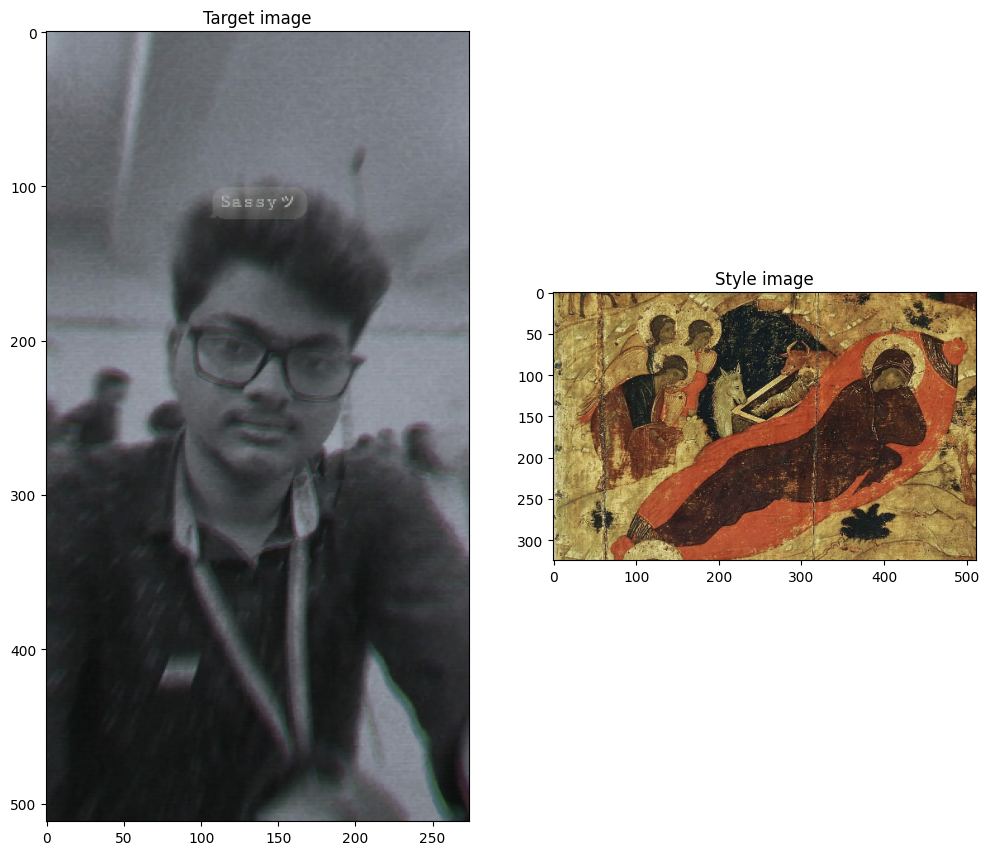

In [5]:
# Let's see the images
content_img=load_image('PROFILE.jpg')
style_img=load_image('../../dataset\images\Andrei_Rublev\Andrei_Rublev_1.jpg')

plt.figure(figsize=(12,12))
plt.subplot(1, 2, 1)
imshow(content_img, 'Target image')
plt.subplot(1, 2, 2)
imshow(style_img, 'Style image')

In [6]:
print(content_img.shape)
print(style_img.shape)

(1, 512, 274, 3)
(1, 325, 512, 3)


In [7]:
# Define the content image representation and load the model
x=tf.keras.applications.vgg19.preprocess_input(content_img*255)# needs preprocessing for the model to be initialized
x=tf.image.resize(x, (256,256))# the vgg19 model takes images in 256
vgg_model=tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable=False
vgg_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
# Chooose the content and style layers
content_layers=['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

In [9]:
# Build the model
def my_model(layer_names):
    # Retrieve the output layers corresponding to the content and style layers
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model=tf.keras.Model([vgg_model.input], outputs)
    return model

In [10]:
style_extractor = my_model(style_layers)
style_outputs = style_extractor(style_img*255)

d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_22']
Received: inputs=Tensor(shape=(1, 325, 512, 3))
  warnings.warn(msg)


In [11]:
# Compute the gram matrix
# Einsum allows defining Tensors by defining their element-wise computation.
# This computation is defined by equation, a shorthand form based on Einstein summation.
def gram_matrix(input_tensor): # input_tensor is of shape ch, n_H, n_W
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) # Unrolls n_H and n_W
    return result/(num_locations)

In [12]:
class entire_model(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(entire_model, self).__init__()
        self.vgg=my_model(style_layers + content_layers)
        self.style_layers=style_layers
        self.content_layers=content_layers
        self.num_style_layers=len(style_layers)
        self.vgg.trainable=False

    def call(self, inputs):
        inputs=inputs*255.0 # Scale back the pixel values
        preprocessed_input=tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs=self.vgg(preprocessed_input)# Pass the preprocessed input to my_model

        # Separate the representations of style and content
        style_outputs, content_outputs=(outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        # Calculate the gram matrix for each layer in the style output. This will be the final style representation
        style_outputs=[gram_matrix(layer) for layer in style_outputs]

        # Store the content and style representation in dictionaries in a layer by layer manner
        content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}
        # Returns a dict of dicts with content and style representations, i.e., gram matrix of the style_layers and
        # the content of the content_layers

In [13]:
# Now we extract the style and content features by calling the above class
extractor=entire_model(style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

results = extractor(tf.constant(content_img))

d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 325, 512, 3))
  warnings.warn(msg)
d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 512, 274, 3))
  warnings.warn(msg)


In [14]:
style_weight=40
content_weight=10

# Custom weights for different style layers
style_weights = {'block1_conv1': 0.2,
                 'block2_conv1': 0.19,
                 'block3_conv1': 0.24,
                 'block4_conv1': 0.11,
                 'block5_conv1': 0.26}
# style_weights = {'block1_conv1': 0.3,
#                  'block2_conv1': 0.45,
#                  'block3_conv1': 0.15,
#                  'block4_conv1': 0.05,
#                  'block5_conv1': 0.05}

In [15]:
def total_cost(outputs):
    style_outputs=outputs['style']
    content_outputs=outputs['content']
    style_loss=tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                        for name in style_outputs.keys()])
    style_loss*=style_weight/len(style_layers)# Normalize

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss*=content_weight/len(content_layers)
    loss=style_loss+content_loss
    return loss

In [16]:
# Define a tf.Variable to contain the image to optimize
generate_image = tf.Variable(content_img)
# Since this is a float image, define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [17]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [18]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_cost(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


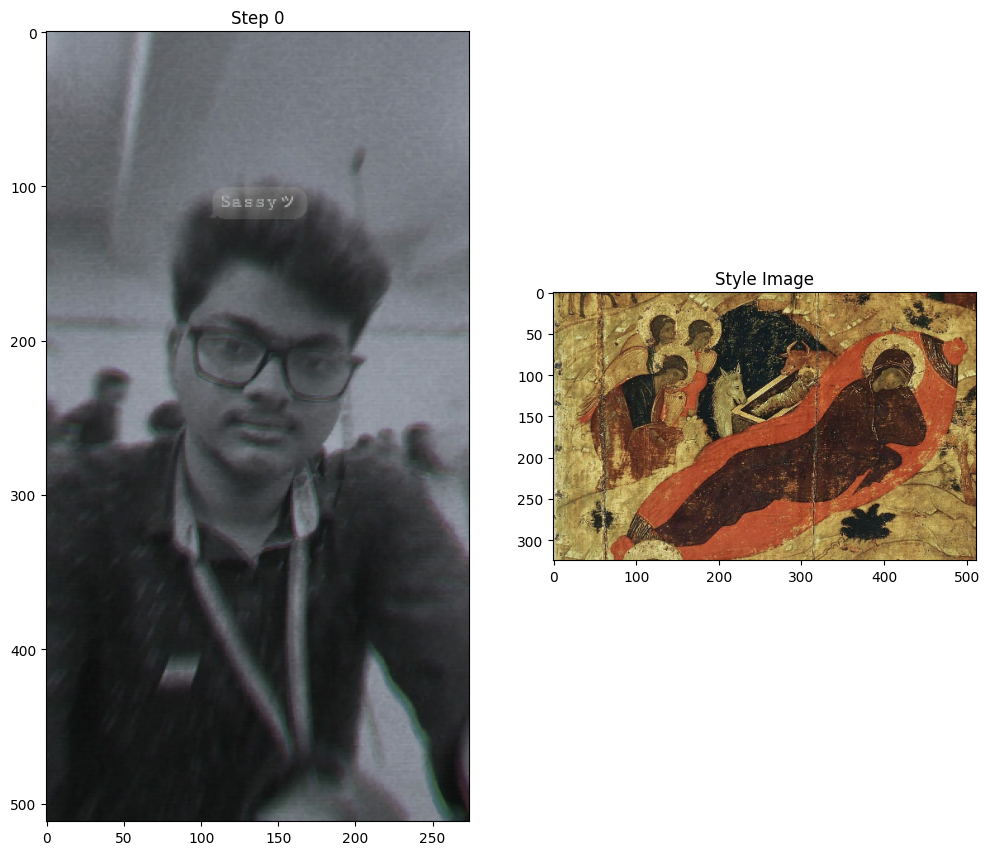

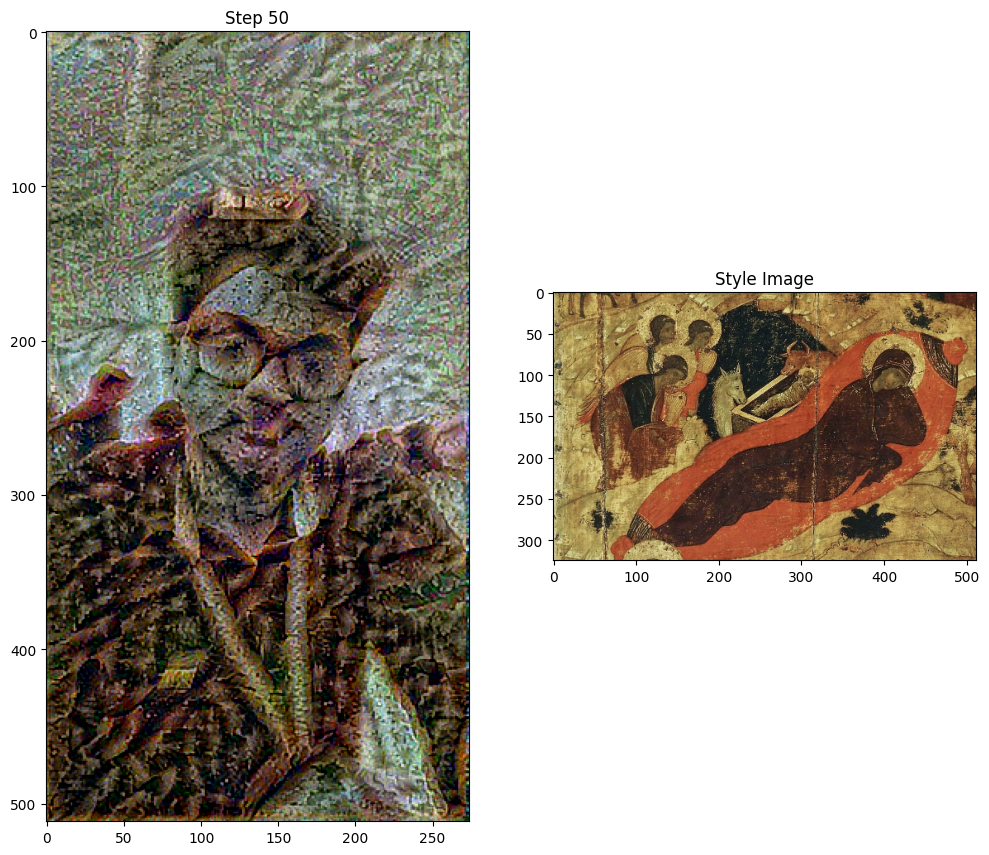

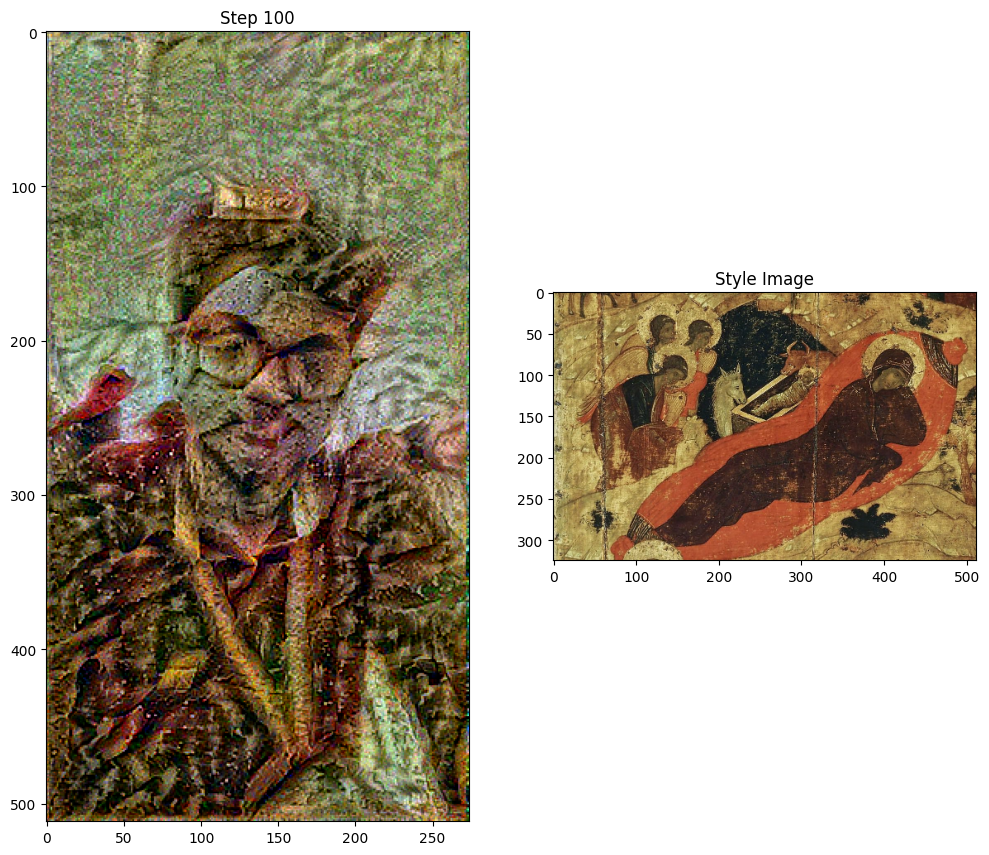

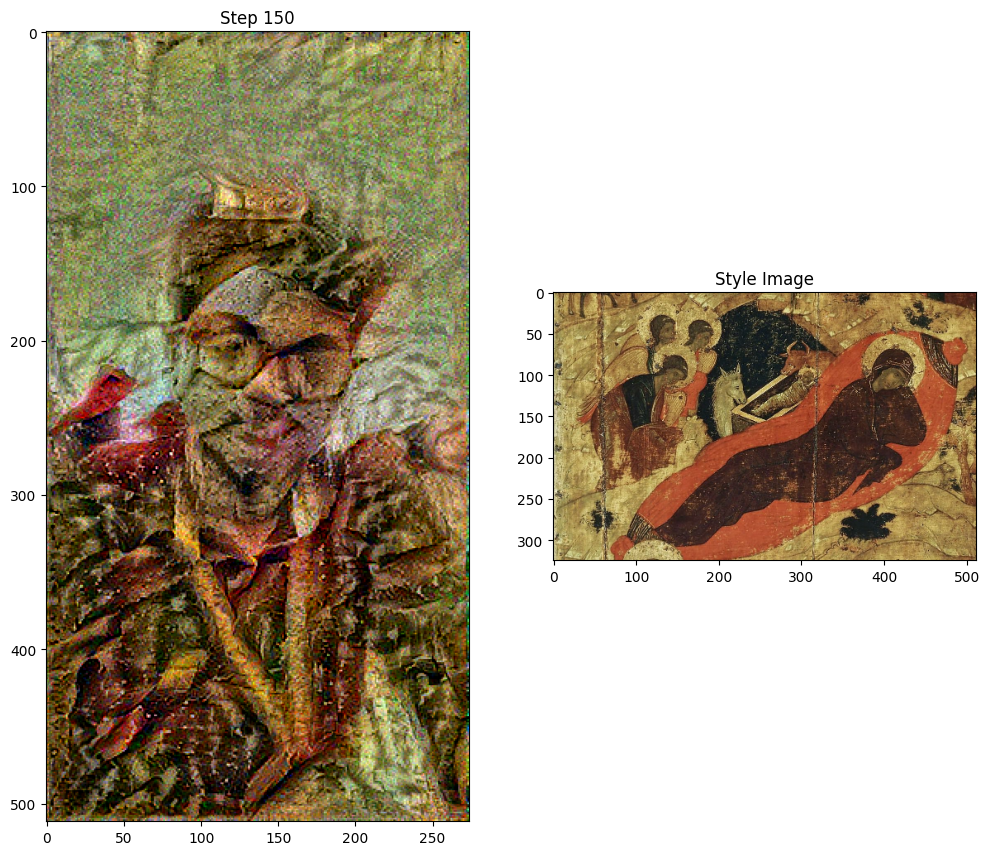

In [19]:
num_iterations=200
for i in range(num_iterations):
    print(i)
    if(i%50==0):
        plt.figure(figsize=(12,12))
        plt.subplot(1, 2, 1)
        imshow(np.squeeze(generate_image.read_value(), 0), f'Step {i}')
        plt.subplot(1, 2, 2)
        imshow(style_img, 'Style Image')
    train_step(generate_image)

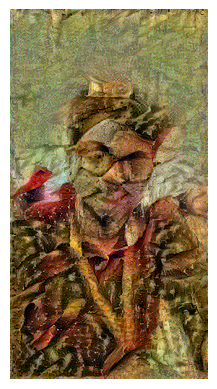

In [20]:
train_step(generate_image)
plt.imshow(np.squeeze(generate_image.read_value(), 0))
plt.axis('off')
fig1 = plt.gcf()
fig1.savefig('new_image.png', bbox_inches='tight')

In [21]:
import os
import json

class StyleTransferCache:
    def __init__(self, style_layers, content_layers):
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.extractor = entire_model(style_layers, content_layers)
        self.cache_dir = 'style_cache'
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def compute_and_save_style(self, style_img_path, style_name):
        """Compute and save style representations for future use"""
        try:
            style_img = load_image(style_img_path)
            style_targets = self.extractor(style_img)['style']
            
            # Ensure all tensors are float32 before saving
            style_dict = {}
            for layer_name, tensor in style_targets.items():
                # Convert to float32 and then to list for JSON serialization
                style_dict[layer_name] = tf.cast(tensor, tf.float32).numpy().tolist()
            
            cache_path = os.path.join(self.cache_dir, f'{style_name}.json')
            with open(cache_path, 'w') as f:
                json.dump(style_dict, f)
                
            print(f"Successfully cached style for {style_name}")
            return style_dict
        except Exception as e:
            print(f"Error in compute_and_save_style: {str(e)}")
            raise
    
    def load_style(self, style_name):
        try:
            cache_path = os.path.join(self.cache_dir, f'{style_name}.json')
            with open(cache_path, 'r') as f:
                style_dict = json.load(f)
            
            # Ensure loaded tensors are float32
            return {k: tf.cast(tf.constant(np.array(v)), tf.float32) 
                   for k, v in style_dict.items()}
        except Exception as e:
            print(f"Error in load_style: {str(e)}")
            raise
    
    def transfer_style(self, content_img_path, style_name, num_iterations=300):
        try:
            content_img = load_image(content_img_path)
            style_targets = self.load_style(style_name)
            content_targets = self.extractor(content_img)['content']
            
            generate_image = tf.Variable(content_img)
            opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
            
            def total_cost(outputs):
                style_outputs = outputs['style']
                content_outputs = outputs['content']
                
                # Ensure all tensors are float32 before calculations
                style_loss = tf.add_n([
                    style_weights[name] * tf.reduce_mean(
                        tf.square(tf.subtract(
                            tf.cast(style_outputs[name], tf.float32),
                            tf.cast(style_targets[name], tf.float32)
                        ))
                    )
                    for name in style_outputs.keys()
                ])
                style_loss *= style_weight/len(style_layers)
                
                content_loss = tf.add_n([
                    tf.reduce_mean(
                        tf.square(tf.subtract(
                            tf.cast(content_outputs[name], tf.float32),
                            tf.cast(content_targets[name], tf.float32)
                        ))
                    )
                    for name in content_outputs.keys()
                ])
                content_loss *= content_weight/len(content_layers)
                
                return style_loss + content_loss
            
            @tf.function()
            def train_step(image):
                with tf.GradientTape() as tape:
                    outputs = self.extractor(image)
                    loss = total_cost(outputs)
                
                grad = tape.gradient(loss, image)
                opt.apply_gradients([(grad, image)])
                image.assign(clip_0_1(image))
            
            for i in range(num_iterations):
                if i % 100 == 0:
                    print(f"Iteration {i}/{num_iterations}")
                train_step(generate_image)
                
            return generate_image.read_value()
        except Exception as e:
            print(f"Error in transfer_style: {str(e)}")
            raise

d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_110']
Received: inputs=Tensor(shape=(1, 325, 512, 3))
  warnings.warn(msg)


Successfully cached style for Andrei_Rublev_style
Successfully cached style representations


d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_110']
Received: inputs=Tensor(shape=(1, 512, 274, 3))
  warnings.warn(msg)


Iteration 0/300
Iteration 100/300
Iteration 200/300
Style transfer completed successfully


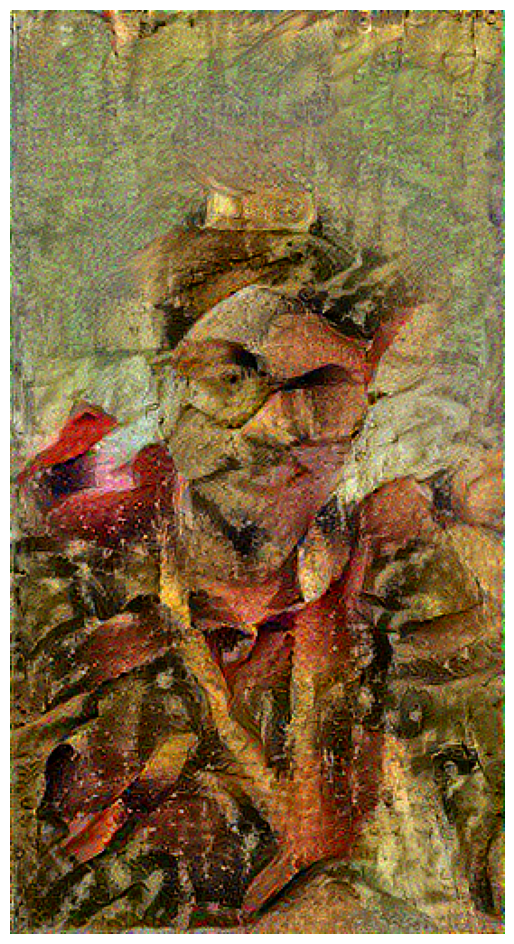

In [24]:
import json
# Initialize the cache system
style_transfer = StyleTransferCache(style_layers, content_layers)

# First time: compute and cache style representations
try:
    style_transfer.compute_and_save_style('../../dataset/images/Andrei_Rublev/Andrei_Rublev_1.jpg', 'Andrei_Rublev_style')
    print("Successfully cached style representations")
except Exception as e:
    print(f"Error caching style: {str(e)}")

# Apply style transfer using cached representations
try:
    stylized_image = style_transfer.transfer_style('PROFILE.jpg', 'Andrei_Rublev_style', num_iterations=300)
    
    # Display and save the result
    plt.figure(figsize=(12,12))
    plt.imshow(np.squeeze(stylized_image, 0))
    plt.axis('off')
    plt.savefig('cached_style_output.png', bbox_inches='tight')
    print("Style transfer completed successfully")
except Exception as e:
    print(f"Error applying style transfer: {str(e)}")

d:\miniconda\envs\aashuenv\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_44']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


Saved model weights.
Saved optimizer configuration.
Saved precomputed style features.
Loaded model weights.
Loaded optimizer configuration.
Loaded precomputed style features.


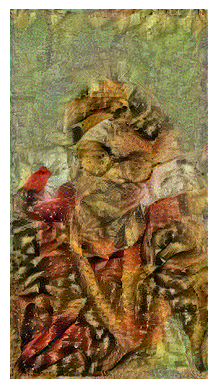

In [25]:
# Ensure the model is built by calling it on some input data
dummy_input = tf.random.normal([1, 256, 256, 3])  # Create a dummy input with the same shape as your input images
_ = extractor(dummy_input)  # Call the model to build it

# Save the model weights after training
extractor.save_weights('style_transfer_model.weights.h5')
print("Saved model weights.")

# Save the optimizer configuration
opt_config = opt.get_config()
with open('optimizer_config.pkl', 'wb') as f:
    pickle.dump(opt_config, f)
print("Saved optimizer configuration.")

# Save the style features
with open('style_features.pkl', 'wb') as f:
    pickle.dump(style_targets, f)
print("Saved precomputed style features.")

# Function to generate a new stylized image using the loaded model
def generate_stylized_image(content_image_path):
    # Load the new content image
    content_img = load_image(content_image_path)
    generate_image = tf.Variable(content_img)

    # Load the model weights
    extractor.load_weights('style_transfer_model.weights.h5')
    print("Loaded model weights.")

    # Load the optimizer configuration
    with open('optimizer_config.pkl', 'rb') as f:
        opt_config = pickle.load(f)
    opt = tf.optimizers.Adam.from_config(opt_config)
    print("Loaded optimizer configuration.")

    # Load the precomputed style features
    with open('style_features.pkl', 'rb') as f:
        style_targets = pickle.load(f)
    print("Loaded precomputed style features.")

    # Generate the stylized image
    for i in range(300):  # Reduced iterations for quick generation
        train_step(generate_image)

    # Display the stylized image
    plt.imshow(np.squeeze(generate_image.read_value(), 0))
    plt.axis('off')
    plt.show()

# Example usage:
# Uncomment the line below and replace 'path_to_new_content_image.jpg' with the path to your new content image
generate_stylized_image('PROFILE.jpg')
